가짜 제조 공장, 생성자

In [1]:
from tensorflow.keras.layers import Conv2D, Dense, Reshape, UpSampling2D, Activation, LeakyReLU, BatchNormalization, Dropout, Flatten, Input
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import mnist

import numpy as np
import matplotlib.pyplot as plt

In [2]:
generator= Sequential()
generator.add(Dense(128*7*7, input_dim= 100, activation= LeakyReLU(0.2)))
# 'Dense(128*7*7)'에서 128은 임의로 정한 노드의 수이고
# 7*7은 'UpSampling2D'를 사용하기에 28*28에서 각각 2이를 나눠 14*14 / 2 => 7*7

# 'LeakyReLU(0.2)'에서 LeakyReLU는 ReLU함수에서 x의 값이 음수이면 0이 되는 부분
# 을 보안하기 위해 0이하에서도 작은 값을 갖게하는 함수로 여기서는 0<= : * 0.2 

generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size= 5, padding= 'same')) 
# 'kernel_size= 5'는 5*5의 크기를 가진 커널
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size= 5, padding= 'same', activation= 'tanh'))

진위를 가려내는 장치, 판별자

In [3]:
discriminator= Sequential()
discriminator.add(Conv2D(64, kernel_size= 5, strides= 2, input_shape= (28, 28, 1), padding= 'same'))
discriminator.add(Activation(LeakyReLU(.2)))
discriminator.add(Dropout(.3))
discriminator.add(Conv2D(128, kernel_size= 5, strides= 2, padding= 'same'))
discriminator.add(Activation(LeakyReLU(.2)))
discriminator.add(Dropout(.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation= 'sigmoid'))
discriminator.compile(loss= 'binary_crossentropy', optimizer= 'adam')
discriminator.trainable= False

적대적 신경망 실행

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100)]             0         
                                                                 
 sequential_2 (Sequential)   (None, 28, 28, 1)         865281    
                                                                 
 sequential_3 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________
1/1 [==============================] - 1s 557ms/step
epoch: 0 d_loss: 1.0579 g_loss: 0.5815
1/1 [==============================] - 0s 244ms/step
epoch: 1 d_loss: 0.7143 g_loss: 0.6113
1/1 [==============================] - 0s 266ms/step
epoch: 2 d_loss: 0.6953 g_loss: 0.6434
1/1 [==============================

FileNotFoundError: ignored

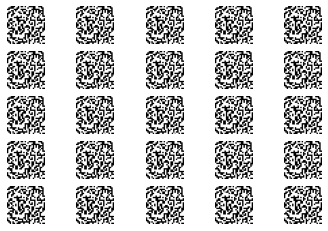

In [4]:
from numpy.random.mtrand import normal
# 생성자 모델 생성
generator= Sequential()
generator.add(Dense(128*7*7, input_dim= 100, activation= LeakyReLU(0.2)))
# 'Dense(128*7*7)'에서 128은 임의로 정한 노드의 수이고
# 7*7은 'UpSampling2D'를 사용하기에 28*28에서 각각 2이를 나눠 14*14 / 2 => 7*7

# 'LeakyReLU(0.2)'에서 LeakyReLU는 ReLU함수에서 x의 값이 음수이면 0이 되는 부분
# 을 보안하기 위해 0이하에서도 작은 값을 갖게하는 함수로 여기서는 0<= : * 0.2 

generator.add(BatchNormalization())
generator.add(Reshape((7, 7, 128)))
generator.add(UpSampling2D())
generator.add(Conv2D(64, kernel_size= 5, padding= 'same')) 
# 'kernel_size= 5'는 5*5의 크기를 가진 커널
generator.add(BatchNormalization())
generator.add(Activation(LeakyReLU(.2)))
generator.add(UpSampling2D())
generator.add(Conv2D(1, kernel_size= 5, padding= 'same', activation= 'tanh'))

# 판별자 모델 생성
discriminator= Sequential()
discriminator.add(Conv2D(64, kernel_size= 5, strides= 2, input_shape= (28, 28, 1), padding= 'same'))
discriminator.add(Activation(LeakyReLU(.2)))
discriminator.add(Dropout(.3))
discriminator.add(Conv2D(128, kernel_size= 5, strides= 2, padding= 'same'))
discriminator.add(Activation(LeakyReLU(.2)))
discriminator.add(Dropout(.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation= 'sigmoid'))
discriminator.compile(loss= 'binary_crossentropy', optimizer= 'adam')
discriminator.trainable= False

# 생성자와 판별자 모델을 연결시키는 gan 모델 생성
ginput= Input(shape= (100, ))
dis_output= discriminator(generator(ginput))
gan= Model(ginput, dis_output)
gan.compile(loss= 'binary_crossentropy', optimizer= 'adam')
gan.summary()

# 신경망을 실행
def gan_train(epoch, batch_size, saving_interval):

  # MNIST 데이터 불러오기
  (x_train, _), (_, _)= mnist.load_data()
  x_train= x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')

  x_train= (x_train - 127.5) / 127.5

  true= np.ones((batch_size, 1))
  fake= np.zeros((batch_size, 1))

  for i in range(epoch):
    idx= np.random.randint(0, x_train.shape[0], batch_size)
    imgs= x_train[idx]
    d_loss_real= discriminator.train_on_batch(imgs, true)
    noise= np.random.normal(0, 1, (batch_size, 100))
    gen_imgs= generator.predict(noise)
    d_loss_fake= discriminator.train_on_batch(imgs, fake)

    d_loss= .5*np.add(d_loss_real, d_loss_fake)
    g_loss= gan.train_on_batch(noise, true)
                               
    print('epoch: %d' % i, 'd_loss: %.4f' % d_loss, 'g_loss: %.4f' % g_loss)

  if i % saving_interval == 0:
    
    noise= np.random.normal(0, 1, (25, 100))
    gen_imgs= generator.predict(noise)

    gen_imgs = .5 * gen_imgs + .5

    fig, axs= plt.subplots(5, 5)
    count= 0
    for j in range(5):
      for k in range(5):
        axs[j, k].imshow(gen_imgs[count, :, :, 0], cmap= 'gray')
        axs[j, k].axis('off')
        count += 1
    fig.savefig('gan_images/gan_mnist_%d.png' % i)

gan_train(2001, 32, 200)                           